<a href="https://colab.research.google.com/github/yutao-data/Sepsis_Gene_KnowledgeGraph_Ontology/blob/main/Sepsis_Pathways_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sepsis Pathways

## Libraries Import

In [ ]:
!pip install owlready2
!pip install networkx

In [ ]:
import requests
from owlready2 import *
from time import sleep
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
import networkx as nx

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Ontology Import & Definition

In [ ]:
def load_ontology(ontology_path):
    try:
        onto = get_ontology(ontology_path).load()
        return onto
    except Exception as e:
        print(f"Initial attempt failed: {e}")
        print("Retrying...")
        sleep(2)
        try:
            onto = get_ontology(ontology_path).load()
            return onto
        except Exception as e:
            print(f"Retry attempt failed: {e}")
            raise

ontology_path = "/content/drive/MyDrive/stagelisn2024-main/Owl/enriched_ppio_ontology2.owl"
onto = load_ontology(ontology_path)

Initial attempt failed: Cannot download 'http://purl.obolibrary.org/obo/TEMP/'!
Retrying...


In [ ]:
with onto:
    class Gene(Thing):
        pass

    class KeggPathway(Thing):
        pass

    class isPartOfPathway(ObjectProperty):
        domain = [Gene]
        range = [KeggPathway]

## Get KEGG Pathways List

In [ ]:
def fetch_kegg_pathways():
    base_url = "http://rest.kegg.jp"
    response = requests.get(f"{base_url}/list/pathway/hsa")
    pathways = response.text.strip().split("\n")
    pathway_dict = {}
    for pathway in pathways:
        pathway_id, description = pathway.split("\t")
        pathway_dict[pathway_id] = description
    return pathway_dict

kegg_pathways = fetch_kegg_pathways()
kegg_pathways

{'hsa01100': 'Metabolic pathways - Homo sapiens (human)',
 'hsa01200': 'Carbon metabolism - Homo sapiens (human)',
 'hsa01210': '2-Oxocarboxylic acid metabolism - Homo sapiens (human)',
 'hsa01212': 'Fatty acid metabolism - Homo sapiens (human)',
 'hsa01230': 'Biosynthesis of amino acids - Homo sapiens (human)',
 'hsa01232': 'Nucleotide metabolism - Homo sapiens (human)',
 'hsa01250': 'Biosynthesis of nucleotide sugars - Homo sapiens (human)',
 'hsa01240': 'Biosynthesis of cofactors - Homo sapiens (human)',
 'hsa00010': 'Glycolysis / Gluconeogenesis - Homo sapiens (human)',
 'hsa00020': 'Citrate cycle (TCA cycle) - Homo sapiens (human)',
 'hsa00030': 'Pentose phosphate pathway - Homo sapiens (human)',
 'hsa00040': 'Pentose and glucuronate interconversions - Homo sapiens (human)',
 'hsa00051': 'Fructose and mannose metabolism - Homo sapiens (human)',
 'hsa00052': 'Galactose metabolism - Homo sapiens (human)',
 'hsa00053': 'Ascorbate and aldarate metabolism - Homo sapiens (human)',
 'hsa

## Get Pathways Gene Pairs

In [ ]:
def fetch_kegg_genes_for_pathway(pathway_id):
    """
    Get genes associated with a KEGG pathway.
    Args:
        pathway_id (str): KEGG pathway ID.
    Returns:
        list: List of genes associated with the pathway.
    """
    base_url = "http://rest.kegg.jp"
    response = requests.get(f"{base_url}/link/hsa/{pathway_id}")
    genes = response.text.strip().split("\n")
    gene_list = []
    for gene in genes:
        parts = gene.split("\t")
        if len(parts) > 1 and ":" in parts[1]:
            gene_list.append(parts[1].split(":")[1])
    return gene_list

def find_gene_instance(gene):
    """
    Find a gene instance in the ontology.
    Args:
        gene (str): Gene ID.
    Returns:
        tuple: Gene instance and search patterns.
    """
    search_patterns = [
        f"*Gene_{gene}",
        f"*_{gene}",
        f"*{gene}"
    ]
    for pattern in search_patterns:
        gene_instance = onto.search_one(iri=pattern)
        if gene_instance:
            return gene_instance, search_patterns
    return None, search_patterns

for pathway_id, description in list(kegg_pathways.items()):
    pathway_instance = KeggPathway(f"Pathway_{pathway_id.replace(':', '_')}")
    pathway_instance.label = description
    genes = fetch_kegg_genes_for_pathway(pathway_id)
    print(f"Pathway {pathway_id} associated genes: {genes}")
    for gene in genes:
        if gene == "50":
            print(f"Skipping gene {gene}")
            continue
        gene_instance, search_patterns = find_gene_instance(gene)
        if gene_instance:
            print(f"Associating gene {gene} with pathway {pathway_id}")
            gene_instance.isPartOfPathway = [pathway_instance]
        else:
            gene_instances = list(onto.Gene.instances())

Streaming output truncated to the last 5000 lines.
Associating gene 817 with pathway hsa05152
Associating gene 818 with pathway hsa05152
Associating gene 820 with pathway hsa05152
Associating gene 836 with pathway hsa05152
Associating gene 841 with pathway hsa05152
Associating gene 8411 with pathway hsa05152
Associating gene 842 with pathway hsa05152
Associating gene 843 with pathway hsa05152
Associating gene 8625 with pathway hsa05152
Associating gene 8717 with pathway hsa05152
Associating gene 8767 with pathway hsa05152
Associating gene 8772 with pathway hsa05152
Associating gene 8844 with pathway hsa05152
Associating gene 8877 with pathway hsa05152
Associating gene 8915 with pathway hsa05152
Associating gene 9103 with pathway hsa05152
Associating gene 9114 with pathway hsa05152
Associating gene 929 with pathway hsa05152
Associating gene 972 with pathway hsa05152
Associating gene 9902 with pathway hsa05152
Pathway hsa05100 associated genes: ['10092', '10093', '10094', '10095', '10096

## Onto Check and Visualization

In [ ]:
# Check is there one Gene connect with multiple Pathways
multiple_pathway_genes = []

for gene in onto.Gene.instances():
    if len(set(gene.isPartOfPathway)) > 1:
        multiple_pathway_genes.append(gene.name)

if multiple_pathway_genes:
    print("Gene Connect with Multiple Pathways")
    for gene_name in multiple_pathway_genes:
        print(gene_name)
else:
    print("No Gene Connect with Multiple Pathways")

No Gene Connect with Multiple Pathways


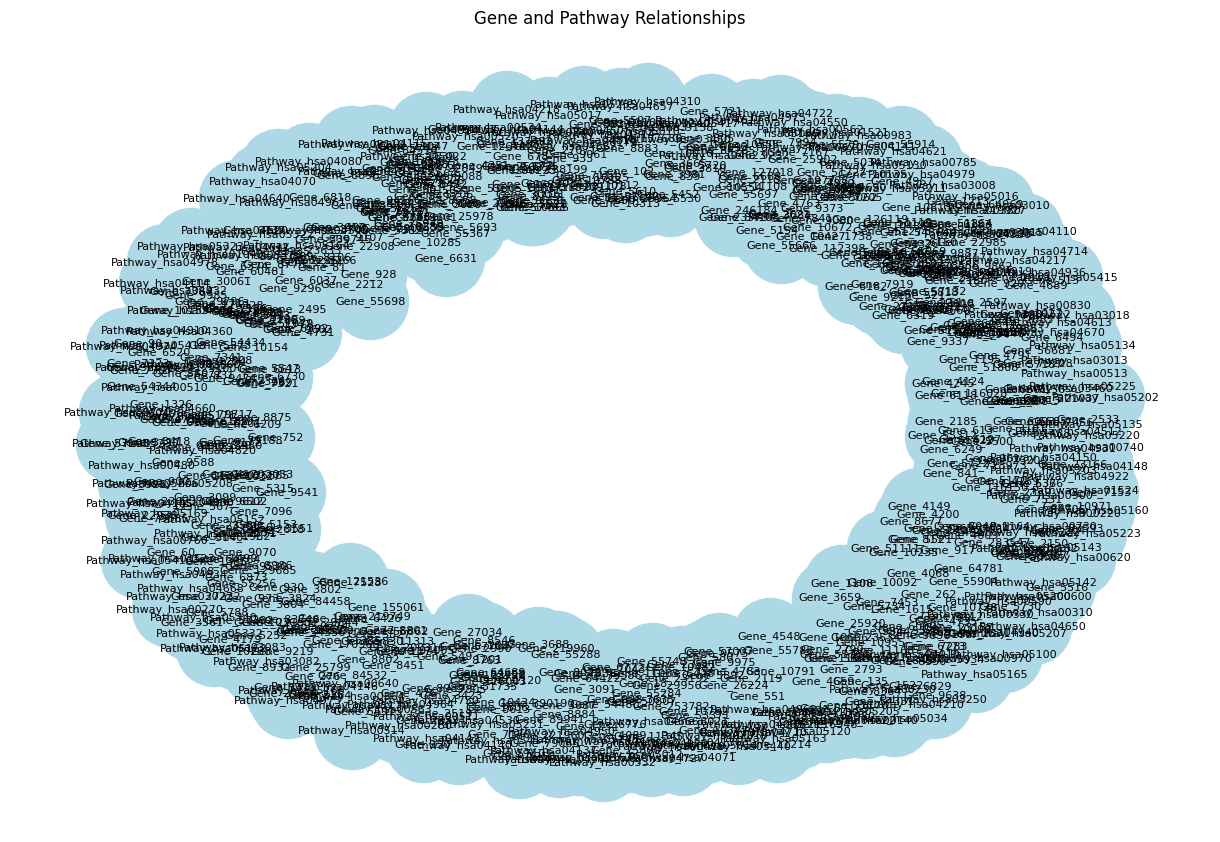

In [ ]:
G = nx.DiGraph()

for gene in onto.Gene.instances():
    gene_name = gene.name
    for pathway in gene.isPartOfPathway:
        pathway_name = pathway.name
        G.add_node(gene_name, label='Gene')
        G.add_node(pathway_name, label='Pathway')
        G.add_edge(gene_name, pathway_name)

plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="lightblue", font_size=8, font_color="black")
plt.title('Gene and Pathway Relationships')
plt.show()


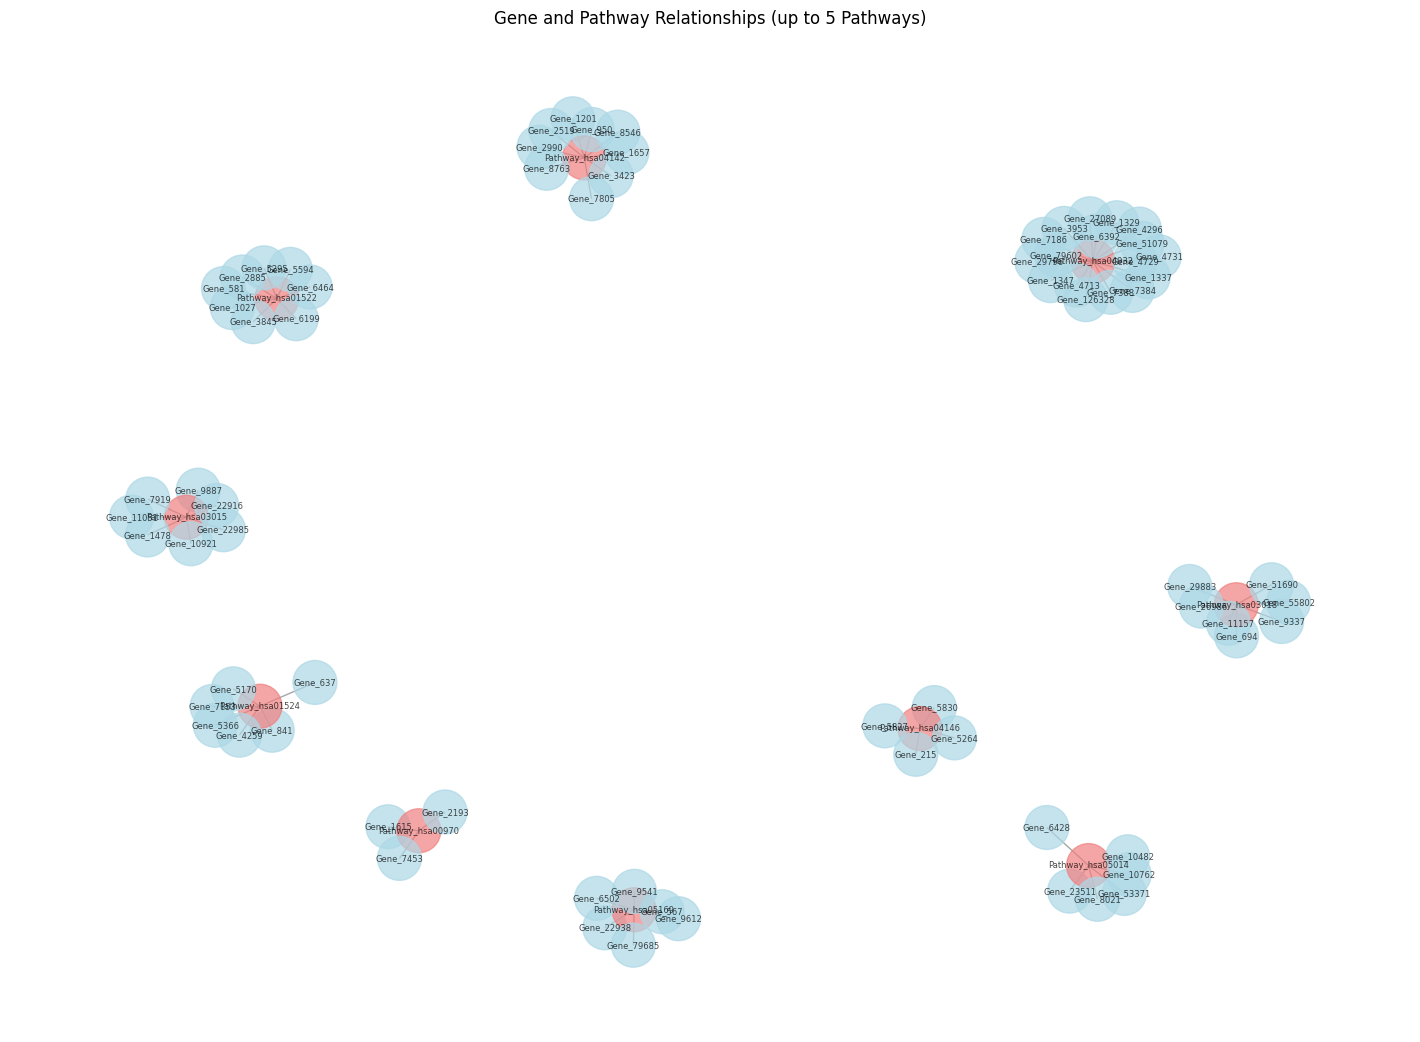

In [ ]:
G = nx.Graph()

pathway_count = 0
max_pathways = 10
selected_pathways = set()

for gene in onto.Gene.instances():
    gene_name = gene.name
    for pathway in gene.isPartOfPathway:
        pathway_name = pathway.name
        if pathway_name not in selected_pathways:
            if pathway_count >= max_pathways:
                break
            selected_pathways.add(pathway_name)
            pathway_count += 1
        if pathway_name in selected_pathways:
            G.add_node(gene_name, label='Gene', color='lightblue')
            G.add_node(pathway_name, label='Pathway', color='lightcoral')
            G.add_edge(gene_name, pathway_name)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42)

node_colors = [G.nodes[node]['color'] for node in G.nodes()]

for node in G.nodes:
    if G.degree(node) > 1 and G.nodes[node]['label'] == 'Gene':
        G.nodes[node]['color'] = 'yellow'

nx.draw(G, pos, with_labels=True, node_size=1000, node_color=node_colors, font_size=6, font_color="black", edge_color='gray', alpha=0.7)
plt.title('Gene and Pathway Relationships (up to 5 Pathways)')
plt.show()

## Save the Updated Ontology

In [ ]:
onto.save(file="/content/drive/MyDrive/stagelisn2024-main/Owl/enriched_ppio_ontology_with_kegg_Pathways.owl")
print("Ontology saved as enriched_ppio_ontology_with_kegg_Pathways.owl")

Ontology saved as enriched_ppio_ontology_with_kegg_Pathways.owl
